##Data Setup

In [1]:
import kagglehub
import shutil
import os
import numpy as np

In [2]:
!gdown 14lX_JgofYZLbIkjPf7rXmBOpVIfMudDo -O kaggle.json
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
path = kagglehub.dataset_download("juliusmaliwat/wildtrack")
target_dir = "Data"
os.makedirs(target_dir, exist_ok=True)
shutil.move(os.path.join(path, 'Wildtrack'), target_dir)

Downloading...
From: https://drive.google.com/uc?id=14lX_JgofYZLbIkjPf7rXmBOpVIfMudDo
To: /content/kaggle.json
100% 69.0/69.0 [00:00<00:00, 285kB/s]


100%|██████████| 6.33G/6.33G [01:29<00:00, 75.7MB/s]

Extracting files...


'Data/Wildtrack'

In [3]:
# wildtrack_mvdetr_deepsort_two_stage

!gdown 1qheoDqsu7CHuur6fnzP8aYIBTBfkIfII -O tracking_output.txt
!gdown 14YS9GrPuhIJGvVz6jvhGfyO1an90Z180 -O tracking_events.txt

Downloading...
From: https://drive.google.com/uc?id=1qheoDqsu7CHuur6fnzP8aYIBTBfkIfII
To: /content/tracking_output.txt
100% 14.6k/14.6k [00:00<00:00, 41.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=14YS9GrPuhIJGvVz6jvhGfyO1an90Z180
To: /content/tracking_events.txt
100% 101k/101k [00:00<00:00, 1.61MB/s]


In [4]:
# ground truth
!gdown 1zx-8_piwOp4UsdtAe__5y0exiygDBWq2 -O gt.txt

Downloading...
From: https://drive.google.com/uc?id=1zx-8_piwOp4UsdtAe__5y0exiygDBWq2
To: /content/gt.txt
100% 156k/156k [00:00<00:00, 3.73MB/s]


In [5]:
import pandas as pd

df_tracking = pd.read_csv("tracking_output.txt", delim_whitespace=True, header=None, names=["frame", "X_idx", "Y_idx", "pred_id"])
df_gt = pd.read_csv("gt.txt", delim_whitespace=True, header=None, names=["frame", "X_idx", "Y_idx", "gt_id"])
df_events = pd.read_csv("tracking_events.txt", sep="\t")

df_events = df_events.merge(
    df_tracking[["frame", "pred_id", "X_idx", "Y_idx"]],
    on=["frame", "pred_id"],
    how="left"
).rename(columns={"X_idx": "X_pred", "Y_idx": "Y_pred"})

df_events = df_events.merge(
    df_gt[["frame", "gt_id", "X_idx", "Y_idx"]],
    on=["frame", "gt_id"],
    how="left"
).rename(columns={"X_idx": "X_gt", "Y_idx": "Y_gt"})

df_switch = df_events[df_events["error_type"] == "SWITCH"]
df_miss = df_events[df_events["error_type"] == "MISS"]
df_fp = df_events[df_events["error_type"] == "FP"]

/tmp/ipython-input-235275094.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_tracking = pd.read_csv("tracking_output.txt", delim_whitespace=True, header=None, names=["frame", "X_idx", "Y_idx", "pred_id"])
/tmp/ipython-input-235275094.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_gt = pd.read_csv("gt.txt", delim_whitespace=True, header=None, names=["frame", "X_idx", "Y_idx", "gt_id"])


## Dataset Object

### bbox completo, sqrt(area), diviso max

In [6]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import json
from tqdm import tqdm
import numpy as np

class WildtrackDataset():
    """
    Wildtrack dataset implementation.
    Handles loading camera parameters, images, and projections.
    """

    # Constants for BEV grid and bbox size
    ORIGIN_X = -3.0
    ORIGIN_Y = -9.0
    GRID_STEP = 0.025
    BBOX_WIDTH = 0.5  # meters
    BBOX_HEIGHT = 1.8  # meters
    NB_WIDTH = 480
    NB_HEIGHT = 1440


    def __init__(self):

        # Hardcoded dataset paths
        self.name = 'wildtrack'
        base_dir = "Data/Wildtrack"
        self.images_dir = os.path.join(base_dir, "Image_subsets")
        self.annotations_dir = os.path.join(base_dir, "annotations_positions")
        self.intrinsics_dir = os.path.join(base_dir, "calibrations/intrinsic_zero")
        self.extrinsics_dir = os.path.join(base_dir, "calibrations/extrinsic")
        self.rectangles_path = os.path.join(base_dir, "rectangles.pom")

        # Loaded resources (to be populated by load())
        self.rvecs = []
        self.tvecs = []
        self.camera_matrices = []
        self.dist_coeffs = []
        self.frames = []
        self.visibility_map = None


    def load(self):
        """
        Load intrinsics, extrinsics, frame IDs, and visibility map.
        """
        self.rvecs, self.tvecs = self._load_extrinsics(self.extrinsics_dir)
        self.camera_matrices, self.dist_coeffs = self._load_intrinsics(self.intrinsics_dir)
        self.frames = self._load_frame_ids()
        #self.visibility_map = self._load_visibility_map()


    def load_image(self, frame_id, cam_id):
        """
        Load an image for a given frame and camera.

        Args:
            frame_id (int): Frame ID
            cam_id (int): Camera ID

        Returns:
            np.ndarray: Image array
        """
        img_path = os.path.join(self.images_dir, f"C{cam_id + 1}", f"{frame_id:08}.png")
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")

        img = cv2.imread(img_path)
        if img is None:
            raise IOError(f"Failed to read image: {img_path}")

        return img

    def project_bev_to_image(self, x_idx, y_idx, cam_id = None):
        """
        Project BEV grid coordinate to 2D bounding boxes in all cameras.

        Args:
            x_idx (int): X index in the BEV grid
            y_idx (int): Y index in the BEV grid

        Returns:
            list of dict: Per-camera projected bounding boxes and corners
        """
        cx = self.ORIGIN_X + self.GRID_STEP * x_idx
        cy = self.ORIGIN_Y + self.GRID_STEP * y_idx
        cz = 0.0  # Ground plane

        results = []
        cameras_to_process = range(len(self.camera_matrices)) if cam_id is None else [cam_id]
        for cam_id in cameras_to_process:
            R, _ = cv2.Rodrigues(self.rvecs[cam_id])
            T = self.tvecs[cam_id].reshape(3, 1)
            camera_matrix = self.camera_matrices[cam_id]
            dist_coeff = self.dist_coeffs[cam_id]

            # Compute direction and orthogonal vector
            camera_pos = -R.T @ T
            dir_vec = np.array([cx, cy, cz]) - camera_pos.flatten()
            dir_vec /= np.linalg.norm(dir_vec)
            ortho = np.array([-dir_vec[1], dir_vec[0]])

            # Define 3D bounding box corners
            bottom_center = np.array([cx, cy, cz])
            w = self.BBOX_WIDTH / 2
            h = self.BBOX_HEIGHT

            corners_world = [
                bottom_center + np.array([-ortho[0]*w, -ortho[1]*w, 0]),
                bottom_center + np.array([ ortho[0]*w,  ortho[1]*w, 0]),
                bottom_center + np.array([ ortho[0]*w,  ortho[1]*w, h]),
                bottom_center + np.array([-ortho[0]*w, -ortho[1]*w, h])
            ]

            # Project to image
            corners_2d, _ = cv2.projectPoints(
                np.array(corners_world),
                self.rvecs[cam_id],
                self.tvecs[cam_id],
                camera_matrix,
                dist_coeff
            )
            corners_2d = corners_2d.reshape(-1, 2)

            x_min, y_min = corners_2d.min(axis=0)
            x_max, y_max = corners_2d.max(axis=0)

            bbox = [int(x_min), int(y_min), int(x_max), int(y_max)]

            results.append({
                "cam_id": cam_id,
                "bbox": bbox,
                "corners": corners_2d
            })

        return results

    def get_crop_from_bev(self, frame_id, x_idx, y_idx):
        """
        Get cropped images for a given BEV detection.

        Args:
            frame_id (int): Frame ID
            x_idx (int): X index in the BEV grid
            y_idx (int): Y index in the BEV grid

        Returns:
            list: List of cropped image arrays, one per camera
        """
        crops = []

        projections = self.project_bev_to_image(x_idx, y_idx)

        for proj in projections:
            cam_id = proj["cam_id"]
            bbox = proj["bbox"]
            x1, y1, x2, y2 = bbox

            try:
                img = self.load_image(frame_id, cam_id)
            except (FileNotFoundError, IOError):
                continue

            h, w = img.shape[:2]
            if x1 < 0 or y1 < 0 or x2 > w or y2 > h or x2 <= x1 or y2 <= y1:
                continue

            crop = img[y1:y2, x1:x2]
            crops.append(crop)

        return crops

    def get_frame_ids(self):
        """
        Get list of available frame IDs in the dataset.

        Returns:
            list of int: List of frame IDs
        """
        return self.frames
    def get_train_frame_ids(self):
        """
        Get list of frame IDs for training split.

        Returns:
            list of int: List of frame IDs used for training.
        """
        return [frame_id for frame_id in self.frames if frame_id <= 1799]

    def get_test_frame_ids(self):
        """
        Get list of frame IDs for test split.

        Returns:
            list of int: List of frame IDs used for evaluation/test.
        """
        # Wildtrack ufficiale: test set dai frame 1800 in avanti
        return [frame_id for frame_id in self.frames if frame_id >= 1800]

    def get_camera_ids(self):
        """
        Get list of available camera IDs in the dataset.

        Returns:
            list of int: List of camera IDs
        """
        # Wildtrack ha 7 camere numerate da 0 a 6
        return list(range(7))

    def get_ground_truth(self, split=None, with_tracking=False):
        """
        Extract ground truth detections or tracking annotations from WildTrack dataset.

        Args:
            split (str or None): 'train', 'test', or None for all data.
            with_tracking (bool): If True, includes track IDs (personID).

        Returns:
            list: Ground truth list:
                - if with_tracking=False: [[frame_id, x_idx, y_idx], ...]
                - if with_tracking=True: [[frame_id, x_idx, y_idx, track_id], ...]
        """
        annotations_dir = self.annotations_dir
        ground_truth = []

        # Determine valid frame IDs based on split
        valid_frame_ids = None
        if split == "train":
            valid_frame_ids = set(self.get_train_frame_ids())
        elif split == "test":
            valid_frame_ids = set(self.get_test_frame_ids())

        # Process annotation files
        for filename in sorted(os.listdir(annotations_dir)):
            if not filename.endswith('.json'):
                continue

            frame_id = int(filename.replace(".json", ""))

            if valid_frame_ids is not None and frame_id not in valid_frame_ids:
                continue

            json_path = os.path.join(annotations_dir, filename)
            with open(json_path, "r") as f:
                annotations = json.load(f)

            for person in annotations:
                positionID = person["positionID"]
                x_idx, y_idx = self._position_id_to_bev_indices(positionID)

                if with_tracking:
                    track_id = person["personID"]
                    ground_truth.append([frame_id, x_idx, y_idx, track_id])
                else:
                    ground_truth.append([frame_id, x_idx, y_idx])
        print(f"Loading {len(ground_truth)} for split {split}")
        return ground_truth
    def get_visibility(self, x_idx, y_idx):
        """
        Return how many cameras can see the BEV cell at (x_idx, y_idx).

        Args:
            x_idx (int): BEV grid x-index
            y_idx (int): BEV grid y-index

        Returns:
            int: Number of cameras seeing the position
        """
        if self.visibility_map is None:
            raise RuntimeError("Call load() before accessing visibility.")
        return self.visibility_map[y_idx, x_idx]


    # =========================
    # Private helper functions
    # =========================

    @staticmethod
    def _load_extrinsics(extrinsics_dir):
        rvecs, tvecs = [], []

        files = sorted(os.listdir(extrinsics_dir))
        for file in files:
            if file.endswith('.xml'):
                tree = ET.parse(os.path.join(extrinsics_dir, file))
                root = tree.getroot()

                rvec_text = root.find('rvec').text.strip()
                tvec_text = root.find('tvec').text.strip()

                rvec = np.fromstring(rvec_text, sep=' ')
                tvec = np.fromstring(tvec_text, sep=' ') / 100.0  # Convert to meters

                rvecs.append(rvec)
                tvecs.append(tvec)

        return rvecs, tvecs

    @staticmethod
    def _load_intrinsics(intrinsics_dir):
        camera_matrices, dist_coeffs = [], []

        files = sorted(os.listdir(intrinsics_dir))
        for file in files:
            if file.endswith('.xml'):
                tree = ET.parse(os.path.join(intrinsics_dir, file))
                root = tree.getroot()

                camera_data = root.find('camera_matrix').find('data').text.strip()
                camera_matrix = np.fromstring(camera_data, sep=' ').reshape((3, 3))

                dist_data = root.find('distortion_coefficients').find('data').text.strip()
                dist_coeff = np.fromstring(dist_data, sep=' ')

                camera_matrices.append(camera_matrix)
                dist_coeffs.append(dist_coeff)

        return camera_matrices, dist_coeffs

    def _load_frame_ids(self):
        frames = set()
        cam_dirs = [os.path.join(self.images_dir, d) for d in os.listdir(self.images_dir) if os.path.isdir(os.path.join(self.images_dir, d))]

        for cam_dir in cam_dirs:
            for f in os.listdir(cam_dir):
                if f.endswith(".png"):
                    frame_num = int(f.replace(".png", ""))
                    frames.add(frame_num)

        return sorted(list(frames))

    def _position_id_to_bev_indices(self, positionID):
        x_idx = positionID % self.NB_WIDTH
        y_idx = positionID // self.NB_WIDTH
        return int(x_idx), int(y_idx)



    def _load_visibility_map(self):
        """
        Load a weighted visibility map from rectangles.pom using projected bbox area as quality indicator.
        Returns:
            np.ndarray: [NB_HEIGHT, NB_WIDTH] map with weighted visibility scores
        """
        visibility_map = np.zeros((self.NB_HEIGHT, self.NB_WIDTH), dtype=float)

        # Wildtrack camera resolution
        img_w, img_h = 1920, 1080

        with open(self.rectangles_path, "r") as f:
            for line in tqdm(f, desc="Parsing rectangles.pom"):
                if not line.startswith("RECTANGLE"):
                    continue

                parts = line.strip().split()
                if len(parts) < 3:
                    continue

                cam_id = int(parts[1])
                pos_id = int(parts[2])
                visible = "notvisible" not in line

                if not visible:
                    continue

                x_idx, y_idx = self._position_id_to_bev_indices(pos_id)
                if not (0 <= x_idx < self.NB_WIDTH and 0 <= y_idx < self.NB_HEIGHT):
                    continue

                # Proietta solo per la camera specifica
                projection = self.project_bev_to_image(x_idx, y_idx, cam_id=cam_id)
                if not projection:
                    continue

                proj = projection[0]  # Singola proiezione
                x1, y1, x2, y2 = proj["bbox"]

                # Scarta se bbox è fuori immagine o malformato
                if x1 < 0 or y1 < 0 or x2 > img_w or y2 > img_h or x2 <= x1 or y2 <= y1:
                    area = 0
                else:
                    area = (x2 - x1) * (y2 - y1)


                visibility_map[y_idx, x_idx] +=  np.sqrt(area)

        visibility_map /= np.max(visibility_map)


        return visibility_map







## Compute Heatmap

In [7]:
wildtrack_dataset = WildtrackDataset()
wildtrack_dataset.load()


## occlusion

In [8]:
def distance_camera_to_bev(dataset, cam_id, cx, cy, cz=0.0):
    R, _ = cv2.Rodrigues(dataset.rvecs[cam_id])
    T = dataset.tvecs[cam_id].reshape(3, 1)
    cam_center = -R.T @ T  # in world coords
    pos = np.array([cx, cy, cz])
    return np.linalg.norm(pos - cam_center.flatten())


In [10]:
def compute_event_visibility_occlusion(dataset, frame_id, x_idx, y_idx, all_events_bev):
    cam_w, cam_h = 1920, 1080
    cx = dataset.ORIGIN_X + dataset.GRID_STEP * x_idx
    cy = dataset.ORIGIN_Y + dataset.GRID_STEP * y_idx
    base_pos = (x_idx, y_idx)

    total_visible_area = 0

    # Proiezioni del riferimento
    ref_projs = dataset.project_bev_to_image(x_idx, y_idx)
    for proj in ref_projs:
        cam_id = proj["cam_id"]
        ref_bbox = proj["bbox"]
        x1, y1, x2, y2 = ref_bbox

        # Sanity check bbox
        if x2 <= x1 or y2 <= y1 or x2 > cam_w or y2 > cam_h:
            continue

        area_ref = (x2 - x1) * (y2 - y1)
        depth_ref = distance_camera_to_bev(dataset, cam_id, cx, cy)

        # Costruisci maschera con occlusioni
        occ_mask = np.zeros((cam_h, cam_w), dtype=bool)

        for ox, oy in all_events_bev:
            if (ox, oy) == base_pos:
                continue

            other_proj = dataset.project_bev_to_image(ox, oy, cam_id=cam_id)
            if not other_proj:
                continue
            other_bbox = other_proj[0]["bbox"]
            ox1, oy1, ox2, oy2 = other_bbox
            if ox2 <= ox1 or oy2 <= oy1:
                continue

            depth_other = distance_camera_to_bev(dataset, cam_id,
                                                 dataset.ORIGIN_X + dataset.GRID_STEP * ox,
                                                 dataset.ORIGIN_Y + dataset.GRID_STEP * oy)
            if depth_other >= depth_ref:
                continue  # non davanti

            # Aggiorna maschera
            occ_mask[oy1:oy2, ox1:ox2] = True

        # Occlusion patch
        occ_patch = occ_mask[y1:y2, x1:x2]
        area_visible = np.sum(~occ_patch)
        total_visible_area += np.sqrt(area_visible)

    return total_visible_area  # non normalizzato
# Considera solo gli eventi validi con coordinate disponibili
df_valid = df_events[
    ((df_events["error_type"].isin(["FP", "SWITCH", "MATCH"])) & df_events["X_pred"].notna() & df_events["Y_pred"].notna()) |
    ((df_events["error_type"] == "MISS") & df_events["X_gt"].notna() & df_events["Y_gt"].notna())
].copy()
df_valid["vis_score_occlusion"] = np.nan
grouped = df_valid.groupby("frame")

for frame_id, group in tqdm(grouped):
    coords = []
    for _, row in group.iterrows():
        if row["error_type"] in ["FP", "SWITCH", "MATCH"]:
            x, y = int(row["X_pred"]), int(row["Y_pred"])
        elif row["error_type"] == "MISS":
            x, y = int(row["X_gt"]), int(row["Y_gt"])
        coords.append((x, y))

    for idx, (x, y) in zip(group.index, coords):
        vis_area = compute_event_visibility_occlusion(
            dataset=wildtrack_dataset,
            frame_id=frame_id,
            x_idx=x,
            y_idx=y,
            all_events_bev=coords
        )
        df_valid.at[idx, "vis_score_occlusion"] = vis_area
min_val = df_valid["vis_score_occlusion"].min()
max_val = df_valid["vis_score_occlusion"].max()

df_valid["vis_score_occlusion"] = (
    df_valid["vis_score_occlusion"] - min_val
) / (max_val - min_val)

100%|██████████| 40/40 [00:19<00:00,  2.01it/s]


/tmp/ipython-input-3512488744.py:29: RuntimeWarning: invalid value encountered in divide
  match_ratio = np.nan_to_num(match_hist / total)
/tmp/ipython-input-3512488744.py:30: RuntimeWarning: invalid value encountered in divide
  miss_ratio  = np.nan_to_num(miss_hist  / total)
/tmp/ipython-input-3512488744.py:31: RuntimeWarning: invalid value encountered in divide
  fp_ratio    = np.nan_to_num(fp_hist    / total)
/tmp/ipython-input-3512488744.py:32: RuntimeWarning: invalid value encountered in divide
  idsw_ratio  = np.nan_to_num(idsw_hist  / total)


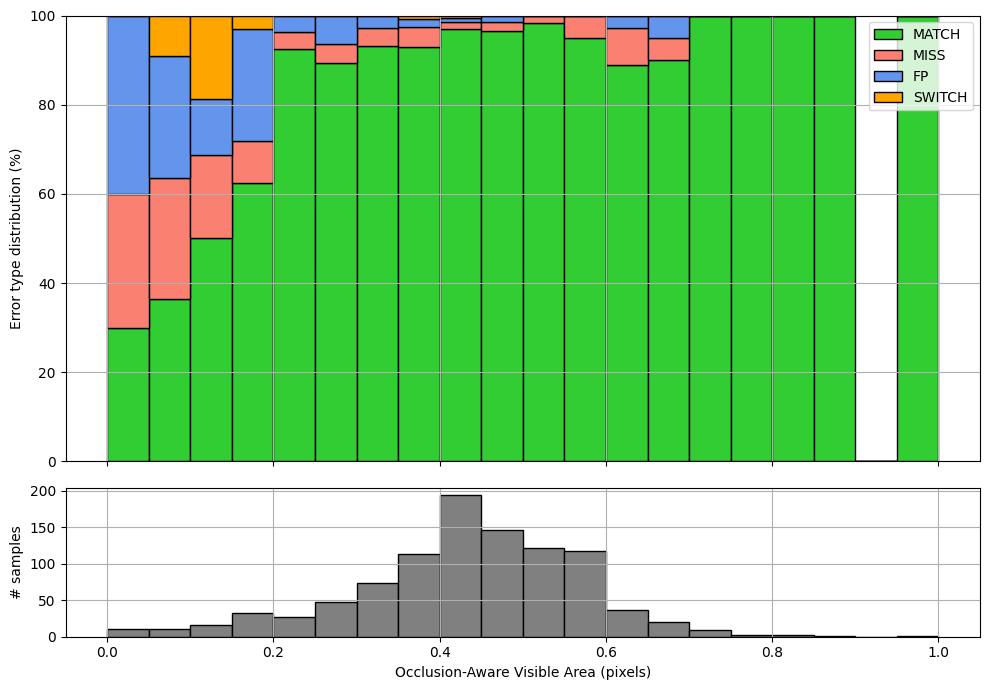

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# === Estrai i visibility scores corretti per occlusion ===
def extract_occlusion_scores(df):
    return df["vis_score_occlusion"].values

match_scores = extract_occlusion_scores(df_valid[df_valid["error_type"] == "MATCH"])
miss_scores  = extract_occlusion_scores(df_valid[df_valid["error_type"] == "MISS"])
fp_scores    = extract_occlusion_scores(df_valid[df_valid["error_type"] == "FP"])
idsw_scores  = extract_occlusion_scores(df_valid[df_valid["error_type"] == "SWITCH"])

# === Binning non normalizzato ===
all_scores = np.concatenate([match_scores, miss_scores, fp_scores, idsw_scores])
num_bins = 20  # o qualsiasi numero tu voglia
bins = np.linspace(all_scores.min(), all_scores.max(), num_bins + 1)

bin_centers = 0.5 * (bins[:-1] + bins[1:])
bar_width = bins[1] - bins[0]

# Frequenze per ciascuna categoria
match_hist, _ = np.histogram(match_scores, bins)
miss_hist,  _ = np.histogram(miss_scores, bins)
fp_hist,    _ = np.histogram(fp_scores, bins)
idsw_hist,  _ = np.histogram(idsw_scores, bins)

# Stack per colonna
total = match_hist + miss_hist + fp_hist + idsw_hist
match_ratio = np.nan_to_num(match_hist / total)
miss_ratio  = np.nan_to_num(miss_hist  / total)
fp_ratio    = np.nan_to_num(fp_hist    / total)
idsw_ratio  = np.nan_to_num(idsw_hist  / total)

# === PLOT ===
fig, (ax_ratio, ax_count) = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# 1. Stacked ratio plot
ax_ratio.bar(bin_centers, match_ratio * 100, width=bar_width, color='limegreen', edgecolor='black', label='MATCH')
ax_ratio.bar(bin_centers, miss_ratio * 100,  width=bar_width, bottom=match_ratio * 100, color='salmon', edgecolor='black', label='MISS')
ax_ratio.bar(bin_centers, fp_ratio * 100,    width=bar_width, bottom=(match_ratio + miss_ratio) * 100, color='cornflowerblue', edgecolor='black', label='FP')
ax_ratio.bar(bin_centers, idsw_ratio * 100,  width=bar_width, bottom=(match_ratio + miss_ratio + fp_ratio) * 100, color='orange', edgecolor='black', label='SWITCH')

ax_ratio.set_ylabel("Error type distribution (%)")
ax_ratio.set_ylim(0, 100)
ax_ratio.legend()
ax_ratio.grid(True)

# 2. Count plot
ax_count.bar(bin_centers, total, width=bar_width, color='gray', edgecolor='black')
ax_count.set_ylabel("# samples")
ax_count.set_xlabel("Occlusion-Aware Visible Area (pixels)")
ax_count.grid(True)

plt.tight_layout()
plt.show()
